First exploration of the data

In [6]:
import pandas as pd

path = 'C:/Users/Surface/Masterarbeit/data/Baseline.xlsx'
path1 = r"C:\Users\Surface\Masterarbeit\data\Baseline.xlsx"

df = pd.read_excel(path1)
#show first 5 rows of the dataset
display(df.head())

#get information about the data and the features
df.describe()
df.info()

,Matrizenradius [mm ],Stempelkantenradius [mm],Blechdicke [mm],Platinenabmessung [mm],1/4 Niederhalterkraft [N],Ziehtiefe [mm],x_Einzug [mm]
0,6,10,2.45,2.0,33752,22,7.1570
1,6,10,2.45,2.0,33752,24,8.1830
2,6,10,2.45,2.0,33752,26,9.2785
3,6,10,2.45,2.0,37502,22,7.0560
4,6,10,2.45,2.0,37502,24,8.0880


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Matrizenradius [mm ]       729 non-null    int64  
 1   Stempelkantenradius [mm]   729 non-null    int64  
 2   Blechdicke [mm]            729 non-null    float64
 3   Platinenabmessung [mm]     729 non-null    float64
 4   1/4 Niederhalterkraft [N]  729 non-null    int64  
 5   Ziehtiefe [mm]             729 non-null    int64  
 6   x_Einzug [mm]              729 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 40.0 KB


In [ ]:
!pip install ydata-profiling --quiet

from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="📋 Datenprofil Baseline", explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 52.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

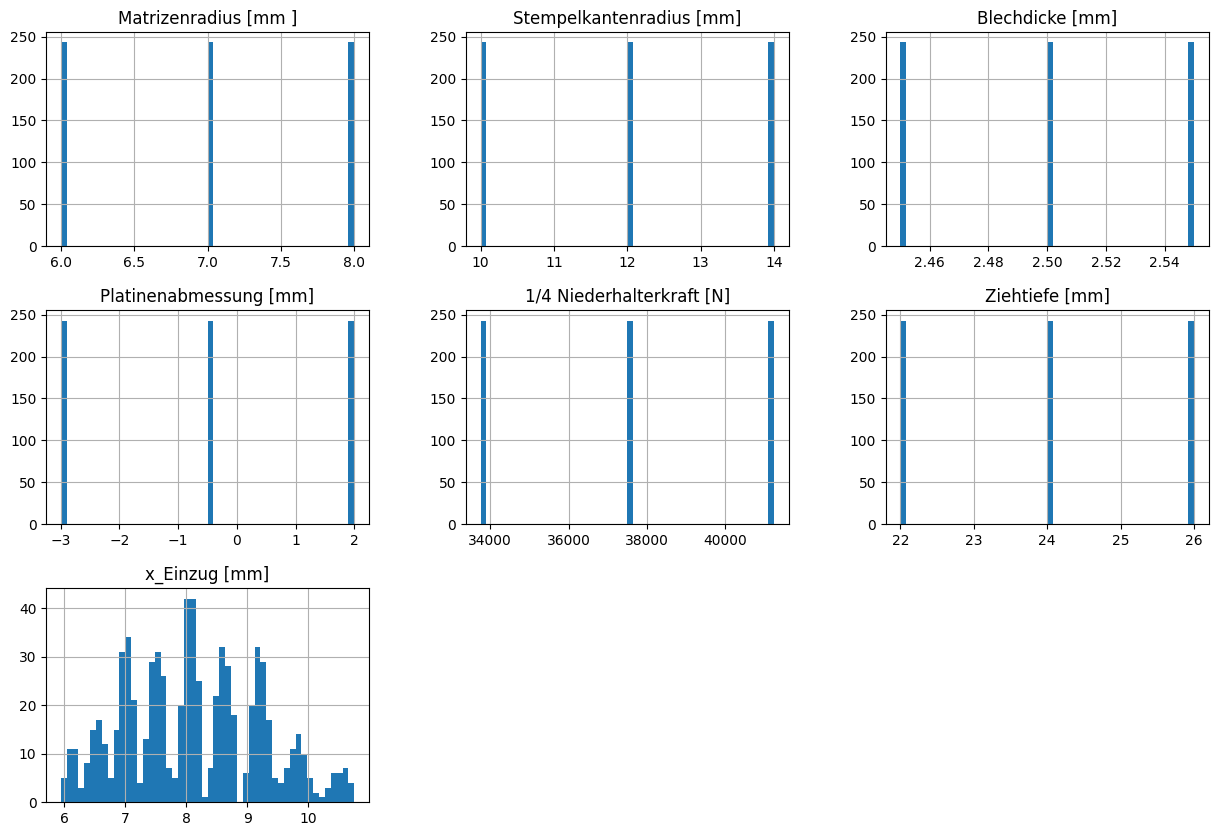

In [4]:
import matplotlib.pyplot as plt

#have a look at the data distribution
df.hist(bins = 50, figsize= (15,10))
plt.show

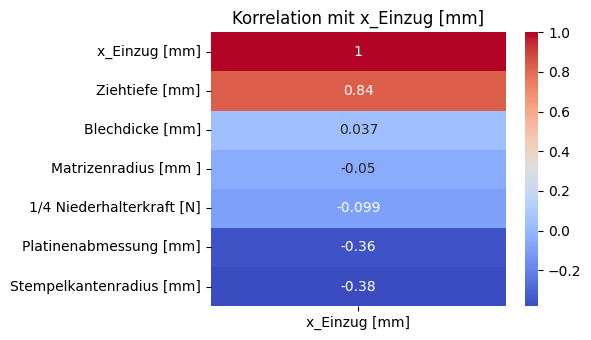

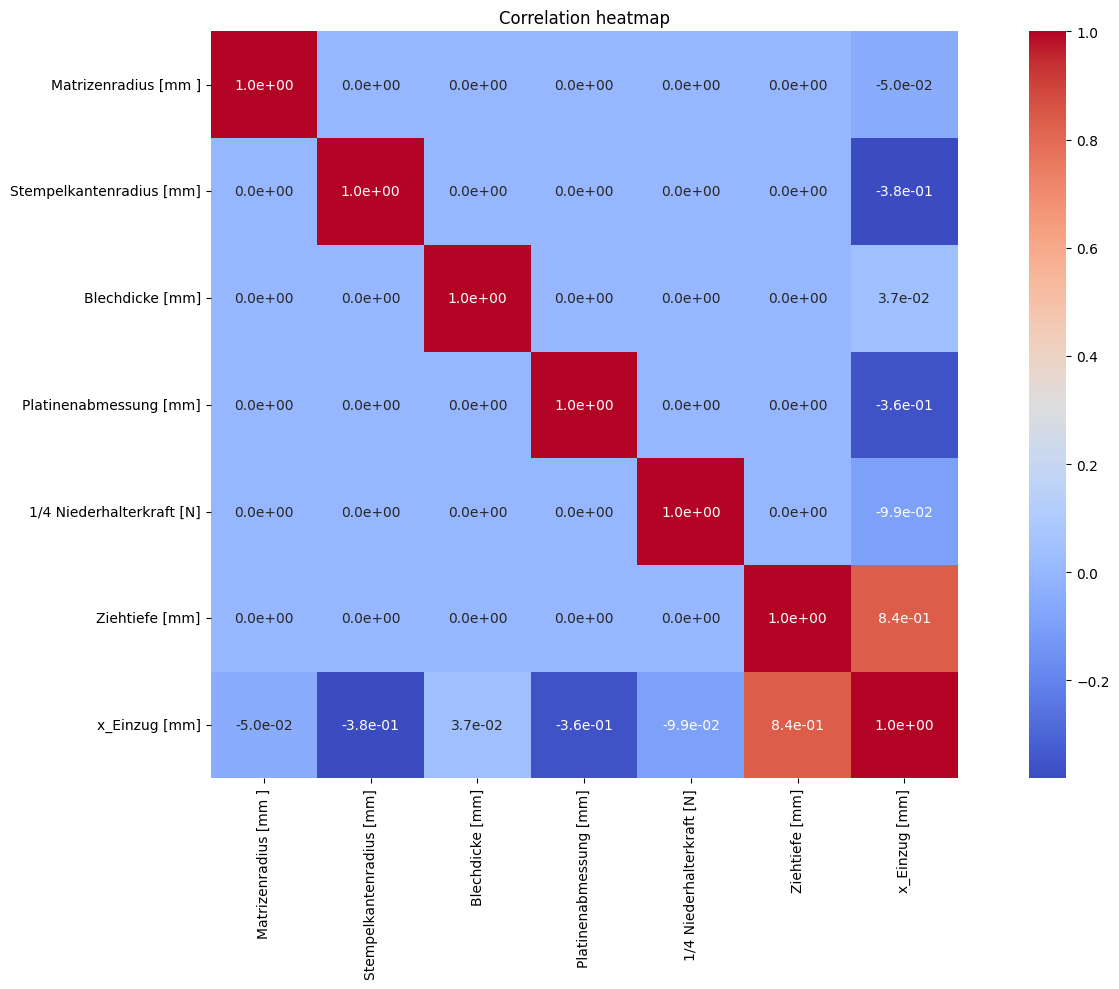

In [5]:
from pandas.plotting import scatter_matrix
import seaborn as sns

target_attr = 'x_Einzug [mm]'

corr_matrix = df.corr(method = 'spearman') #Pearson correlation, assumption relationship is linear
#get a sorted correlation matrix
sorted_corr = corr_matrix[target_attr].sort_values(ascending=False)

#plot figure for the correlation with the target
plt.figure(figsize = (6, len(sorted_corr) * 0.5))
sns.heatmap(sorted_corr.to_frame(), annot= True, cmap = 'coolwarm', cbar = True)
plt.title(f'Korrelation mit {target_attr}')
plt.tight_layout()
plt.show()

#plot full correlation heatmap
plt.figure(figsize=(15 , 10))
sns.heatmap(corr_matrix, annot=True, fmt= '.1e', cmap='coolwarm', cbar=True, square=True)
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()



Transformation Pipeline

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#get the numerical features
data_num = df.drop('x_Einzug [mm]', axis = 1)
#get the target values
data_labels = df['x_Einzug [mm]'].to_numpy()

#three different pipelines for preprocessing the data
#pipeline 1 is used

#Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

#scales data according to median and Interquartildistance, for data with many outliers
data_pipeline1 = Pipeline([
    ('rob_scaler', RobustScaler())
])

#min max scalling for values between 0 and 1 (Normalization)
data_pipeline2 = Pipeline([
    ('Min_Max_Scaler', MinMaxScaler())
])

data_prep = data_pipeline.fit_transform(data_num)
# data_prep1 = data_pipeline1.fit_transform(data_num)
# data_prep2 = data_pipeline2.fit_transform(data_num)
# print(data_prep[:30])
# print(data_prep1[:30])
# print(data_prep2[:30])

X_train, X_test, y_train, y_test = train_test_split(data_prep, data_labels, test_size= 0.2, random_state=42)
print(X_train[:5])
print(y_train[:5])

[[ 0.         -1.22474487 -1.22474487  1.22474487  0.          0.        ]
 [ 0.          0.         -1.22474487  0.         -1.22474487  1.22474487]
 [ 1.22474487  1.22474487  0.         -1.22474487  1.22474487  1.22474487]
 [ 0.          1.22474487  0.          1.22474487  1.22474487  1.22474487]
 [-1.22474487  0.          1.22474487  1.22474487 -1.22474487  0.        ]]
[8.089  9.288  9.06   8.0435 7.678 ]


Gaussian Process

In [7]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [21]:
import gpytorch
import torch
import numpy as np
from sklearn.metrics import r2_score

# Convert NumPy arrays to PyTorch tensors
X_tr = torch.from_numpy(X_train).float()
X_te = torch.from_numpy(X_test).float()
y_tr = torch.from_numpy(y_train).float()
y_te = torch.from_numpy(y_test).float()

# Define an Exact GP Model using a constant mean and an RBF (Radial Basis Function) kernel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  # Constant mean function
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())  # RBF kernel scaled by a learnable factor

    def forward(self, X):
        mean_x = self.mean_module(X)           # Compute the mean of the GP
        covar_x = self.covar_module(X)         # Compute the covariance (kernel)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Define the Gaussian likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialize the GP model with training data and likelihood
model = ExactGPModel(X_tr, y_tr, likelihood)

# Set model and likelihood into training mode
model.train()
likelihood.train()

# Use Adam optimizer to train kernel and likelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Marginal log likelihood is used as the loss function for GP training
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Number of training iterations
training_iter = 100

# Training loop
for i in range(training_iter):
    optimizer.zero_grad()              # Reset gradients
    output = model(X_tr)               # Forward pass
    loss = -mll(output, y_tr)          # Negative marginal log likelihood (to minimize)
    loss.backward()                    # Backpropagation

    # Print progress every 10 iterations
    if i % 10 == 0:
        print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
              f'squared lengthscale: ',
              f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
              f'noise variance: {model.likelihood.noise.item(): .3f}')

    optimizer.step()                   # Update parameters


 Iter 1/100 - Loss:  11.669 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.540 squared lengthscale:   1.526 noise variance:  1.052
 Iter 31/100 - Loss:  1.287 squared lengthscale:   1.715 noise variance:  0.823
 Iter 41/100 - Loss:  1.050 squared lengthscale:   1.832 noise variance:  0.530
 Iter 51/100 - Loss:  0.771 squared lengthscale:   1.919 noise variance:  0.284
 Iter 61/100 - Loss:  0.453 squared lengthscale:   2.001 noise variance:  0.130
 Iter 71/100 - Loss:  0.115 squared lengthscale:   2.091 noise variance:  0.054
 Iter 81/100 - Loss: -0.224 squared lengthscale:   2.195 noise variance:  0.022
 Iter 91/100 - Loss: -0.559 squared lengthscale:   2.318 noise variance:  0.009


Data Plotting

/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 0.999
Coverage: 100.00%


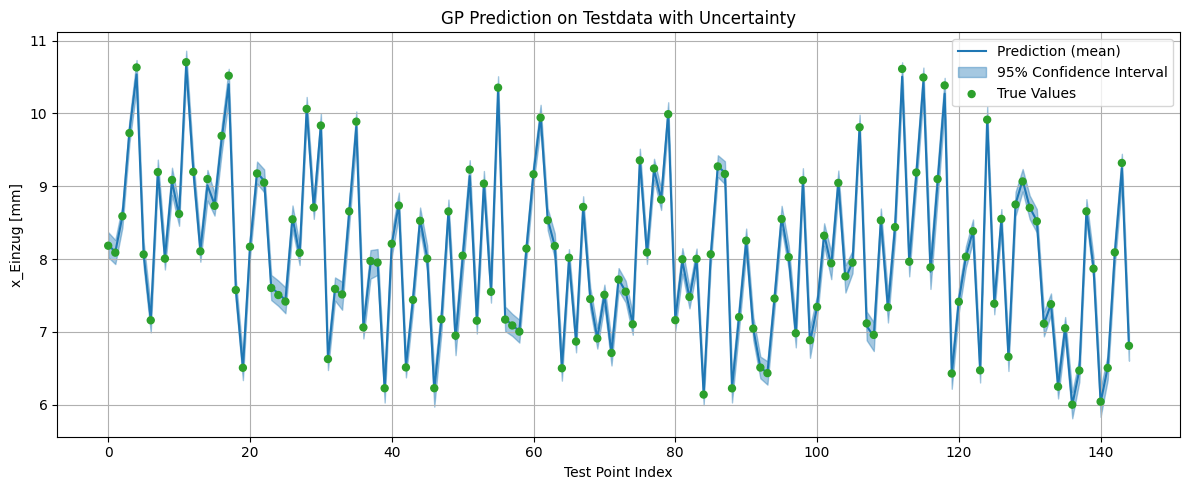

In [28]:
# Switch model and likelihood to evaluation mode
model.eval()
likelihood.eval()

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = model(X_tr)            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
train_mean = y_preds.mean.numpy()
train_stddev = y_preds.stddev.numpy()

# Calculate R² for the train data
r2_test = r2_score(y_tr.numpy(), train_mean)
print(f"R² on Test Data: {r2_test:.3f}")


# Number of test samples
n = len(X_te)

# Predictive distribution for test data (no gradients required)
with torch.no_grad():
    f_preds = model(X_te[:n])            # Latent function predictions
    y_preds = likelihood(f_preds)        # Observed predictions with noise

# Extract mean and standard deviation from predictions
test_mean = y_preds.mean.numpy()
test_stddev = y_preds.stddev.numpy()
true = y_te[:n].numpy()

# Calculate R² for the test data
r2_test = r2_score(true, test_mean)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
gp_lower = test_mean - 2*test_stddev
gp_upper = test_mean + 2*test_stddev

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (true >= gp_lower) & (true <= gp_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
plt.figure(figsize=(12, 5))
x_axis = np.arange(n)

# Plot predicted mean
plt.plot(x_axis, test_mean, label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, gp_lower, gp_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, true, label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("GP Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training mit Cross Validation

In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle = True, random_state= 42)

X = torch.from_numpy(data_prep).float()
y = torch.from_numpy(data_labels).float()

# Number of training iterations
training_iter = 100

r2_scores = []
for train_idx, test_idx in kf.split(data_prep):
  X_tr, X_te = X[train_idx], X[test_idx]
  y_tr, y_te = y[train_idx], y[test_idx]

  # Define the Gaussian likelihood
  likelihood = gpytorch.likelihoods.GaussianLikelihood()

  # Initialize the GP model with training data and likelihood
  model = ExactGPModel(X_tr, y_tr, likelihood)

  # Set model and likelihood into training mode
  model.train()
  likelihood.train()

  # Use Adam optimizer to train kernel and likelihood parameters
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

  # Marginal log likelihood is used as the loss function for GP training
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  # Training loop
  for i in range(training_iter):
      optimizer.zero_grad()              # Reset gradients
      output = model(X_tr)               # Forward pass
      loss = -mll(output, y_tr)          # Negative marginal log likelihood (to minimize)
      loss.backward()                    # Backpropagation

      # Print progress every 10 iterations
      if i % 10 == 0:
          print(f' Iter {i+1:d}/{training_iter:d} - Loss: {loss.item(): .3f}',
                f'squared lengthscale: ',
                f'{model.covar_module.base_kernel.lengthscale.item(): .3f}',
                f'noise variance: {model.likelihood.noise.item(): .3f}')

      optimizer.step()                   # Update parameters

  # Switch model and likelihood to evaluation mode
  model.eval()
  likelihood.eval()

  # Predictive distribution for test data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_tr)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  train_mean = y_preds.mean.numpy()
  train_stddev = y_preds.stddev.numpy()

  # Calculate R² for the train data
  r2_test = r2_score(y_tr.numpy(), train_mean)
  print(f"R² on Test Data: {r2_test:.3f}")

  # Predictive distribution for test data (no gradients required)
  with torch.no_grad():
      f_preds = model(X_te)            # Latent function predictions
      y_preds = likelihood(f_preds)        # Observed predictions with noise

  # Extract mean and standard deviation from predictions
  test_mean = y_preds.mean.numpy()
  test_stddev = y_preds.stddev.numpy()
  true = y_te.numpy()

  # Calculate R² for the test data
  r2_test = r2_score(true, test_mean)
  print(f"R² on Test Data: {r2_test:.3f}")


 Iter 1/100 - Loss:  11.669 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.540 squared lengthscale:   1.526 noise variance:  1.052
 Iter 31/100 - Loss:  1.287 squared lengthscale:   1.715 noise variance:  0.823
 Iter 41/100 - Loss:  1.050 squared lengthscale:   1.832 noise variance:  0.530
 Iter 51/100 - Loss:  0.771 squared lengthscale:   1.919 noise variance:  0.284
 Iter 61/100 - Loss:  0.453 squared lengthscale:   2.001 noise variance:  0.130
 Iter 71/100 - Loss:  0.115 squared lengthscale:   2.091 noise variance:  0.054
 Iter 81/100 - Loss: -0.224 squared lengthscale:   2.195 noise variance:  0.022
 Iter 91/100 - Loss: -0.559 squared lengthscale:   2.318 noise variance:  0.009


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.626 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.197 squared lengthscale:   1.197 noise variance:  1.066
 Iter 21/100 - Loss:  1.539 squared lengthscale:   1.527 noise variance:  1.052
 Iter 31/100 - Loss:  1.286 squared lengthscale:   1.716 noise variance:  0.821
 Iter 41/100 - Loss:  1.048 squared lengthscale:   1.834 noise variance:  0.529
 Iter 51/100 - Loss:  0.768 squared lengthscale:   1.922 noise variance:  0.282
 Iter 61/100 - Loss:  0.449 squared lengthscale:   2.004 noise variance:  0.129
 Iter 71/100 - Loss:  0.111 squared lengthscale:   2.094 noise variance:  0.054
 Iter 81/100 - Loss: -0.230 squared lengthscale:   2.199 noise variance:  0.022
 Iter 91/100 - Loss: -0.565 squared lengthscale:   2.322 noise variance:  0.009


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.619 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.065
 Iter 21/100 - Loss:  1.537 squared lengthscale:   1.527 noise variance:  1.049
 Iter 31/100 - Loss:  1.283 squared lengthscale:   1.716 noise variance:  0.817
 Iter 41/100 - Loss:  1.043 squared lengthscale:   1.833 noise variance:  0.524
 Iter 51/100 - Loss:  0.762 squared lengthscale:   1.921 noise variance:  0.279
 Iter 61/100 - Loss:  0.442 squared lengthscale:   2.003 noise variance:  0.127
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.093 noise variance:  0.053
 Iter 81/100 - Loss: -0.238 squared lengthscale:   2.198 noise variance:  0.022
 Iter 91/100 - Loss: -0.573 squared lengthscale:   2.322 noise variance:  0.009


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.697 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.194 squared lengthscale:   1.197 noise variance:  1.063
 Iter 21/100 - Loss:  1.536 squared lengthscale:   1.527 noise variance:  1.046
 Iter 31/100 - Loss:  1.282 squared lengthscale:   1.715 noise variance:  0.814
 Iter 41/100 - Loss:  1.042 squared lengthscale:   1.832 noise variance:  0.521
 Iter 51/100 - Loss:  0.761 squared lengthscale:   1.919 noise variance:  0.277
 Iter 61/100 - Loss:  0.440 squared lengthscale:   2.001 noise variance:  0.126
 Iter 71/100 - Loss:  0.102 squared lengthscale:   2.090 noise variance:  0.053
 Iter 81/100 - Loss: -0.236 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.569 squared lengthscale:   2.319 noise variance:  0.009


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R² on Test Data: 1.000
R² on Test Data: 1.000
 Iter 1/100 - Loss:  11.586 squared lengthscale:   0.693 noise variance:  0.693
 Iter 11/100 - Loss:  2.183 squared lengthscale:   1.196 noise variance:  1.063
 Iter 21/100 - Loss:  1.531 squared lengthscale:   1.525 noise variance:  1.044
 Iter 31/100 - Loss:  1.276 squared lengthscale:   1.713 noise variance:  0.808
 Iter 41/100 - Loss:  1.034 squared lengthscale:   1.829 noise variance:  0.514
 Iter 51/100 - Loss:  0.750 squared lengthscale:   1.917 noise variance:  0.271
 Iter 61/100 - Loss:  0.427 squared lengthscale:   1.999 noise variance:  0.122
 Iter 71/100 - Loss:  0.087 squared lengthscale:   2.089 noise variance:  0.051
 Iter 81/100 - Loss: -0.254 squared lengthscale:   2.195 noise variance:  0.021
 Iter 91/100 - Loss: -0.589 squared lengthscale:   2.319 noise variance:  0.009
R² on Test Data: 1.000
R² on Test Data: 0.999


/usr/local/lib/python3.11/dist-packages/gpytorch/models/exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
